In [ ]:
%reload_ext autoreload
%autoreload 2

import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import pandas as pd
from pytz import UTC, timezone

from watttime import WattTimeForecast, WattTimeHistorical

import data.s3 as s3u
from plotnine import *

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
requery_results = s3.load_parquetdataframe(f"historical_requery_sim_1000_simple_fit.parquet").drop_duplicates() 
requery_results['unique_id'] = (requery_results['region'].astype(str) + requery_results['init_time'].astype(str)).apply(hash).abs()

In [6]:
requery_results

,point_time,actual_moer,usage,emissions_co2e_lb,energy_usage_mwh,increment,pred_moer,actual_emissions,init_time,region,unique_id
0,2023-03-24 12:25:00+00:00,984.0,0.0,0.0,0.0,Ideal,984.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH,1215105342752658783
1,2023-03-24 12:30:00+00:00,985.0,0.0,0.0,0.0,Ideal,985.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH,1215105342752658783
2,2023-03-24 12:35:00+00:00,986.0,0.0,0.0,0.0,Ideal,986.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH,1215105342752658783
3,2023-03-24 12:40:00+00:00,986.0,0.0,0.0,0.0,Ideal,986.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH,1215105342752658783
4,2023-03-24 12:45:00+00:00,986.0,0.0,0.0,0.0,Ideal,986.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH,1215105342752658783
...,...,...,...,...,...,...,...,...,...,...,...
14194990,2023-03-27 13:15:00+00:00,863.0,0.0,0.0,0.0,Requery 360 minutes,891.4,0.0,2023-03-27 01:37:46+00:00,NYISO_NYC,238692891899445269
14194991,2023-03-27 13:20:00+00:00,891.0,0.0,0.0,0.0,Requery 360 minutes,894.0,0.0,2023-03-27 01:37:46+00:00,NYISO_NYC,238692891899445269
14194992,2023-03-27 13:25:00+00:00,887.0,0.0,0.0,0.0,Requery 360 minutes,894.0,0.0,2023-03-27 01:37:46+00:00,NYISO_NYC,238692891899445269
14194993,2023-03-27 13:30:00+00:00,891.0,0.0,0.0,0.0,Requery 360 minutes,896.1,0.0,2023-03-27 01:37:46+00:00,NYISO_NYC,238692891899445269


In [7]:
totals = requery_results.groupby(["increment", "region", "init_time"])[["actual_emissions", "emissions_co2e_lb"]].sum().reset_index()
totals['unique_id'] = (totals['region'].astype(str) + totals['init_time'].astype(str)).apply(hash).abs()

/tmp/ipykernel_689720/3033715799.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [10]:
ideals = totals.query("increment == 'Ideal'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "ideal_emissions"}, axis =1)
baselines = totals.query("increment == 'Baseline'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "baseline_emissions"}, axis =1)
no_reqs = totals.query("increment == 'No requery'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "no_requery_emissions"}, axis =1)

In [11]:
totals_comp = totals.merge(ideals).merge(baselines).merge(no_reqs)

In [12]:
totals_comp["ideal_diff_pct"] = (totals_comp['actual_emissions'] - totals_comp["ideal_emissions"]) / totals_comp["ideal_emissions"] * 100
totals_comp["baseline_diff_pct"] = -(totals_comp['actual_emissions'] - totals_comp["baseline_emissions"]) / totals_comp["baseline_emissions"] * 100
totals_comp["ideal_diff"] = (totals_comp['actual_emissions'] - totals_comp["ideal_emissions"])
totals_comp["baseline_diff"] = -(totals_comp['actual_emissions'] - totals_comp["baseline_emissions"])
totals_comp["no_requery_diff_pct"] = (totals_comp["no_requery_emissions"] - totals_comp['actual_emissions']) / totals_comp["no_requery_emissions"] * 100
totals_comp["no_requery_diff"] = (totals_comp["no_requery_emissions"] - totals_comp['actual_emissions'])

In [13]:
totals_comp

,increment,region,init_time,actual_emissions,emissions_co2e_lb,unique_id,ideal_emissions,baseline_emissions,no_requery_emissions,ideal_diff_pct,baseline_diff_pct,ideal_diff,baseline_diff,no_requery_diff_pct,no_requery_diff
0,Ideal,CAISO_NORTH,2023-01-01 02:57:27+00:00,5.706667,5.706667,373327306177331981,5.706667,5.821667,5.740500,0.000000,1.975379,0.000000,0.115000,0.589380,0.033833
1,Ideal,CAISO_NORTH,2023-01-01 13:39:42+00:00,5.913667,5.913667,5444840955925993045,5.913667,6.295667,6.013333,0.000000,6.067666,0.000000,0.382000,1.657428,0.099667
2,Ideal,CAISO_NORTH,2023-01-01 15:46:29+00:00,5.952167,5.952167,4603802217327720073,5.952167,6.435333,6.013333,0.000000,7.508029,0.000000,0.483167,1.017184,0.061167
3,Ideal,CAISO_NORTH,2023-01-02 01:51:58+00:00,5.459833,5.459833,4261374480097502106,5.459833,5.953833,5.830833,0.000000,8.297175,0.000000,0.494000,6.362727,0.371000
4,Ideal,CAISO_NORTH,2023-01-02 03:16:43+00:00,5.459667,5.459667,6114682500361860246,5.459667,5.890667,5.830833,0.000000,7.316659,0.000000,0.431000,6.365585,0.371167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98104,Requery 5 minutes,SPP_TX,2023-12-29 01:54:28+00:00,1.057833,0.552100,1069208590835793517,0.069167,8.347833,0.083667,1429.397590,87.328049,0.988667,7.290000,-1164.342629,-0.974167
98105,Requery 5 minutes,SPP_TX,2023-12-29 14:16:03+00:00,3.673000,2.995317,1225850261191975160,3.306333,3.544833,3.590333,11.089828,-3.615591,0.366667,-0.128167,-2.302479,-0.082667
98106,Requery 5 minutes,SPP_TX,2023-12-29 18:48:25+00:00,8.658167,8.459333,4990198671505164187,8.326167,8.683667,8.675833,3.987429,0.293655,0.332000,0.025500,0.203631,0.017667
98107,Requery 5 minutes,SPP_TX,2023-12-29 20:50:42+00:00,8.718000,8.438917,5359906902256074280,8.326167,8.467500,8.771000,4.706047,-2.958370,0.391833,-0.250500,0.604264,0.053000


In [14]:
totals_comp.groupby(["region", "increment"])["no_requery_diff_pct"].mean().reset_index().pivot_table(columns = "increment", index = "region")

/tmp/ipykernel_689720/1077147731.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_689720/1077147731.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


no_requery_diff_pct                                             \
increment                  Ideal    Baseline No requery Requery 360 minutes   
region                                                                        
CAISO_NORTH             8.824198  -67.361283        0.0            0.025755   
ERCOT_EASTTX            5.456733 -588.212482        0.0           -0.967638   
FPL                     0.223025   -2.913494        0.0            0.001803   
LDWP                    2.801491   -3.601779        0.0            0.051793   
NYISO_NYC               0.994399   -2.885886        0.0            0.009692   
PJM_CHICAGO            13.045947   -7.560765        0.0            0.105926   
PJM_DC                  1.288257   -2.642276        0.0            0.017744   
SOCO                    0.625480   -4.101451        0.0            0.000485   
SPP_TX                 27.756218 -392.705774        0.0          -10.785115   

                                                                          \
increment    Requery 240 minutes Requery 180 minutes Requery 120 minutes   
region                                                                     
CAISO_NORTH             0.352345            0.499347            0.350566   
ERCOT_EASTTX           -0.811232           -1.044884         -600.324137   
FPL                     0.000589           -0.002972            0.008099   
LDWP                    0.132314            0.129076            0.233247   
NYISO_NYC              -0.002429           -0.003527            0.014649   
PJM_CHICAGO            -0.250056            0.003752            0.085863   
PJM_DC                  0.062525            0.057006            0.094530   
SOCO                   -0.000497           -0.001079           -0.000635   
SPP_TX                -19.766712          -42.032465          -88.015705   

                                                                       \
increment    Requery 60 minutes Requery 30 minutes Requery 15 minutes   
region                                                                  
CAISO_NORTH            1.049141           0.994541           1.234753   
ERCOT_EASTTX       -3338.118702       -3692.194827       -4165.232327   
FPL                    0.015955           0.032221           0.045067   
LDWP                   0.388050           0.578041           0.663384   
NYISO_NYC              0.005998           0.081138           0.120906   
PJM_CHICAGO           -0.045782           0.610593           0.623133   
PJM_DC                 0.162541           0.189764           0.220921   
SOCO                  -0.003490          -0.007913          -0.021300   
SPP_TX              -110.882250        -115.436202        -111.892504   

                                
increment    Requery 5 minutes  
region                          
CAISO_NORTH           1.638404  
ERCOT_EASTTX      -4167.024552  
FPL                   0.050824  
LDWP                  0.736894  
NYISO_NYC             0.169388  
PJM_CHICAGO           0.879320  
PJM_DC                0.218577  
SOCO                 -0.084724  
SPP_TX             -109.062099

In [15]:
totals_comp.groupby(["region", "increment"])["no_requery_diff_pct"].mean().reset_index().pivot_table(columns = "increment", index = "region")

/tmp/ipykernel_689720/1077147731.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_689720/1077147731.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


no_requery_diff_pct                                             \
increment                  Ideal    Baseline No requery Requery 360 minutes   
region                                                                        
CAISO_NORTH             8.824198  -67.361283        0.0            0.025755   
ERCOT_EASTTX            5.456733 -588.212482        0.0           -0.967638   
FPL                     0.223025   -2.913494        0.0            0.001803   
LDWP                    2.801491   -3.601779        0.0            0.051793   
NYISO_NYC               0.994399   -2.885886        0.0            0.009692   
PJM_CHICAGO            13.045947   -7.560765        0.0            0.105926   
PJM_DC                  1.288257   -2.642276        0.0            0.017744   
SOCO                    0.625480   -4.101451        0.0            0.000485   
SPP_TX                 27.756218 -392.705774        0.0          -10.785115   

                                                                          \
increment    Requery 240 minutes Requery 180 minutes Requery 120 minutes   
region                                                                     
CAISO_NORTH             0.352345            0.499347            0.350566   
ERCOT_EASTTX           -0.811232           -1.044884         -600.324137   
FPL                     0.000589           -0.002972            0.008099   
LDWP                    0.132314            0.129076            0.233247   
NYISO_NYC              -0.002429           -0.003527            0.014649   
PJM_CHICAGO            -0.250056            0.003752            0.085863   
PJM_DC                  0.062525            0.057006            0.094530   
SOCO                   -0.000497           -0.001079           -0.000635   
SPP_TX                -19.766712          -42.032465          -88.015705   

                                                                       \
increment    Requery 60 minutes Requery 30 minutes Requery 15 minutes   
region                                                                  
CAISO_NORTH            1.049141           0.994541           1.234753   
ERCOT_EASTTX       -3338.118702       -3692.194827       -4165.232327   
FPL                    0.015955           0.032221           0.045067   
LDWP                   0.388050           0.578041           0.663384   
NYISO_NYC              0.005998           0.081138           0.120906   
PJM_CHICAGO           -0.045782           0.610593           0.623133   
PJM_DC                 0.162541           0.189764           0.220921   
SOCO                  -0.003490          -0.007913          -0.021300   
SPP_TX              -110.882250        -115.436202        -111.892504   

                                
increment    Requery 5 minutes  
region                          
CAISO_NORTH           1.638404  
ERCOT_EASTTX      -4167.024552  
FPL                   0.050824  
LDWP                  0.736894  
NYISO_NYC             0.169388  
PJM_CHICAGO           0.879320  
PJM_DC                0.218577  
SOCO                 -0.084724  
SPP_TX             -109.062099

In [25]:
totals_comp.query("unique_id == 2127805345538670419")

,increment,region,init_time,actual_emissions,emissions_co2e_lb,unique_id,ideal_emissions,baseline_emissions,no_requery_emissions,ideal_diff_pct,baseline_diff_pct,ideal_diff,baseline_diff,no_requery_diff_pct,no_requery_diff
1079,Ideal,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,0.000000,0.000000,2127805345538670419,0.0,0.003833,0.000167,NaN,100.000000,0.000000,0.003833,100.0,0.000167
9998,Baseline,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,0.003833,6.559583,2127805345538670419,0.0,0.003833,0.000167,inf,-0.000000,0.003833,-0.000000,-2200.0,-0.003667
18917,No requery,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,0.000167,3.397750,2127805345538670419,0.0,0.003833,0.000167,inf,95.652174,0.000167,0.003667,0.0,0.000000
27836,Requery 360 minutes,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,0.001833,4.028800,2127805345538670419,0.0,0.003833,0.000167,inf,52.173913,0.001833,0.002000,-1000.0,-0.001667
36755,Requery 240 minutes,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,0.000500,3.706867,2127805345538670419,0.0,0.003833,0.000167,inf,86.956522,0.000500,0.003333,-200.0,-0.000333
45674,Requery 180 minutes,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,0.002500,4.236317,2127805345538670419,0.0,0.003833,0.000167,inf,34.782609,0.002500,0.001333,-1400.0,-0.002333
54593,Requery 120 minutes,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,0.988833,4.606933,2127805345538670419,0.0,0.003833,0.000167,inf,-25695.652174,0.988833,-0.985000,-593200.0,-0.988667
63512,Requery 60 minutes,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,5.502167,6.922533,2127805345538670419,0.0,0.003833,0.000167,inf,-143434.782609,5.502167,-5.498333,-3301200.0,-5.502000
72431,Requery 30 minutes,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,6.086667,7.011767,2127805345538670419,0.0,0.003833,0.000167,inf,-158682.608696,6.086667,-6.082833,-3651900.0,-6.086500
81350,Requery 15 minutes,ERCOT_EASTTX,2023-02-06 02:57:10+00:00,6.867500,7.047167,2127805345538670419,0.0,0.003833,0.000167,inf,-179052.173913,6.867500,-6.863667,-4120400.0,-6.867333


In [26]:
requery_results.query("unique_id == '2127805345538670419'")

,point_time,actual_moer,usage,emissions_co2e_lb,energy_usage_mwh,increment,pred_moer,actual_emissions,init_time,region,unique_id
3362795,2023-02-06 02:55:00+00:00,2.0,0.0,0.0,0.0,Ideal,2.0,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
3362796,2023-02-06 03:00:00+00:00,1.0,0.0,0.0,0.0,Ideal,1.0,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
3362797,2023-02-06 03:05:00+00:00,1.0,0.0,0.0,0.0,Ideal,1.0,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
3362798,2023-02-06 03:10:00+00:00,1.0,0.0,0.0,0.0,Ideal,1.0,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
3362799,2023-02-06 03:15:00+00:00,2.0,0.0,0.0,0.0,Ideal,2.0,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
...,...,...,...,...,...,...,...,...,...,...,...
3364385,2023-02-06 14:35:00+00:00,1191.0,0.0,0.0,0.0,Requery 360 minutes,1155.5,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
3364386,2023-02-06 14:40:00+00:00,1191.0,0.0,0.0,0.0,Requery 360 minutes,1158.6,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
3364387,2023-02-06 14:45:00+00:00,1191.0,0.0,0.0,0.0,Requery 360 minutes,1158.4,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419
3364388,2023-02-06 14:50:00+00:00,1191.0,0.0,0.0,0.0,Requery 360 minutes,1160.6,0.0,2023-02-06 02:57:10+00:00,ERCOT_EASTTX,2127805345538670419


In [17]:
totals_comp.groupby(["region", "increment"]).agg(mean_no_rq_diff = ("no_requery_diff_pct", "mean"),
                                                 median_no_rq_diff = ("no_requery_diff_pct", "median"))

/tmp/ipykernel_689720/2291357045.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


mean_no_rq_diff  median_no_rq_diff
region      increment                                              
CAISO_NORTH Ideal                       8.824198           2.653849
            Baseline                  -67.361283          -1.910790
            No requery                  0.000000           0.000000
            Requery 360 minutes         0.025755           0.000000
            Requery 240 minutes         0.352345           0.000000
...                                          ...                ...
SPP_TX      Requery 120 minutes       -88.015705           0.102997
            Requery 60 minutes       -110.882250           0.214195
            Requery 30 minutes       -115.436202           0.338762
            Requery 15 minutes       -111.892504           0.299571
            Requery 5 minutes        -109.062099           0.337299

[99 rows x 2 columns]

/tmp/ipykernel_689720/2180159998.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


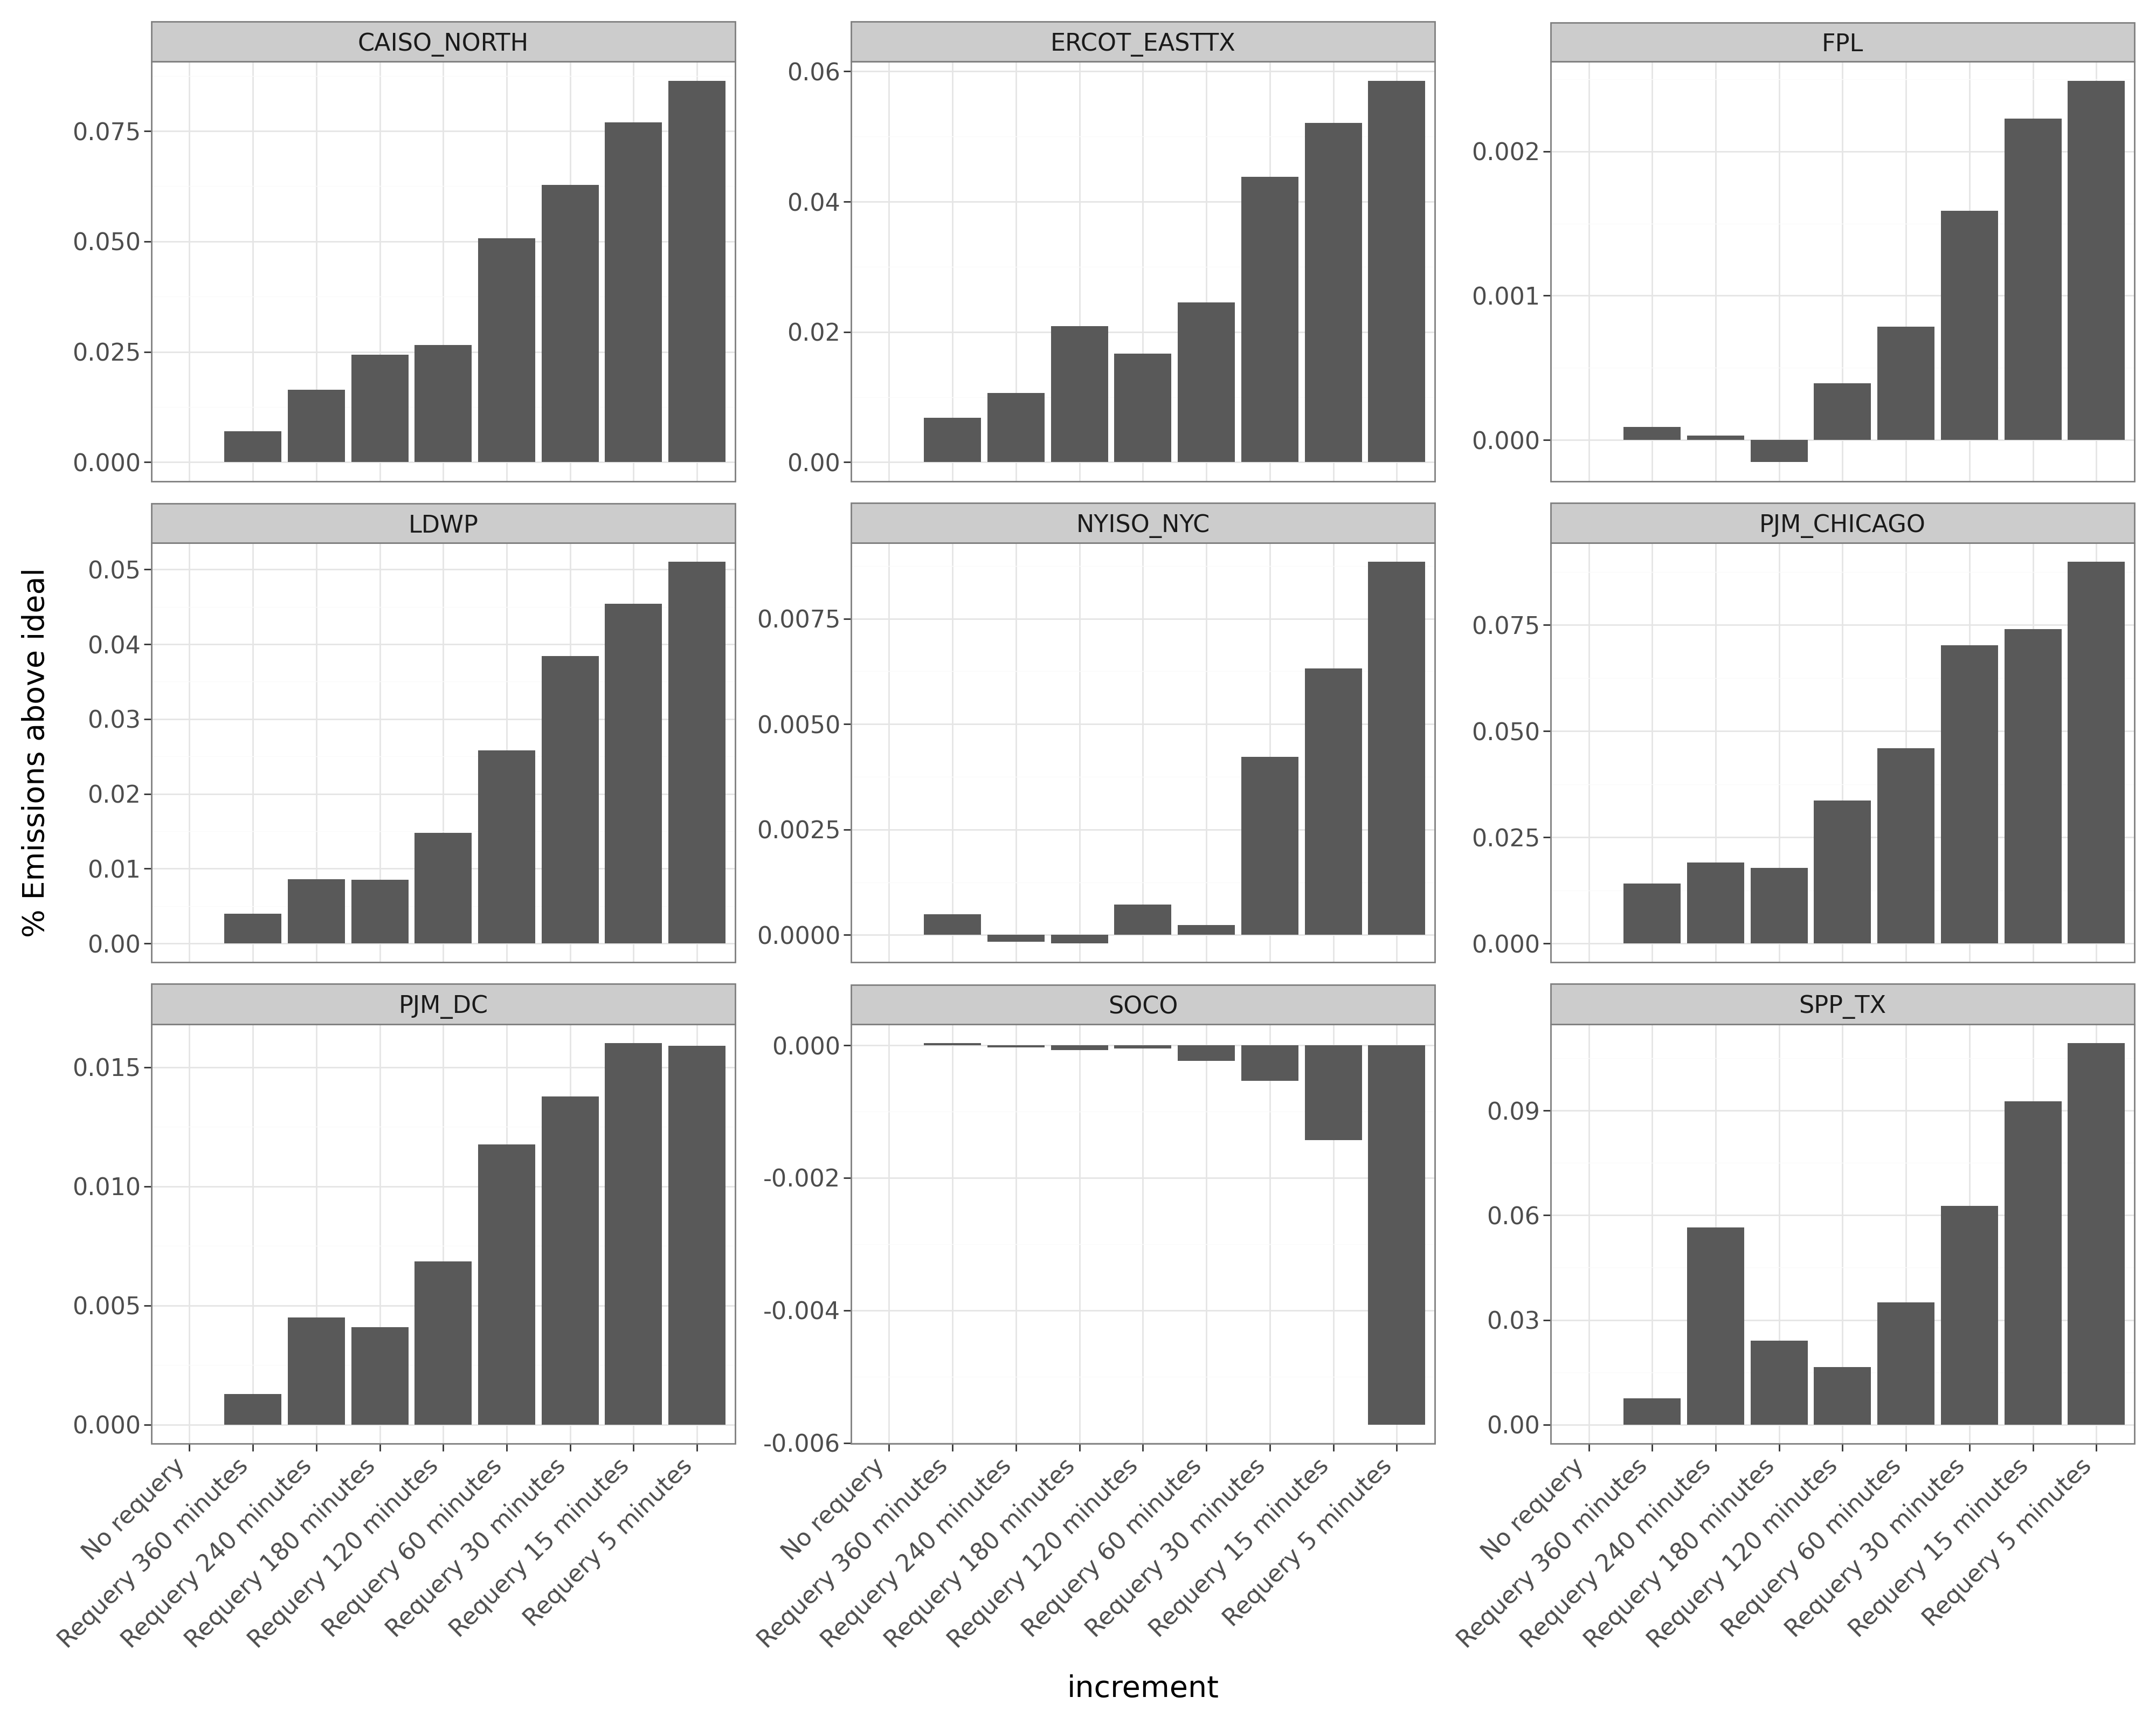

In [18]:
plot_dat = totals_comp.groupby(["region", "increment"])["no_requery_diff"].mean().reset_index()

(ggplot(plot_dat.query("~increment.isin(['Baseline', 'Ideal'])"), aes(x = "increment", y = "no_requery_diff")) + geom_bar(stat = "identity") + facet_wrap("~region", scales = "free_y") + theme_bw(base_size=20) +
     theme(figure_size=(20, 16),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions above ideal"))

In [36]:
totals_comp

,increment,region,init_time,actual_emissions,emissions_co2e_lb,unique_id
0,Ideal,CAISO_NORTH,2023-01-01 02:57:27+00:00,5.706667,5.706667,373327306177331981
1,Ideal,CAISO_NORTH,2023-01-01 13:39:42+00:00,5.913667,5.913667,5444840955925993045
2,Ideal,CAISO_NORTH,2023-01-01 15:46:29+00:00,5.952167,5.952167,4603802217327720073
3,Ideal,CAISO_NORTH,2023-01-02 01:51:58+00:00,5.459833,5.459833,4261374480097502106
4,Ideal,CAISO_NORTH,2023-01-02 03:16:43+00:00,5.459667,5.459667,6114682500361860246
...,...,...,...,...,...,...
98104,Requery 5 minutes,SPP_TX,2023-12-29 01:54:28+00:00,1.057833,0.552100,1069208590835793517
98105,Requery 5 minutes,SPP_TX,2023-12-29 14:16:03+00:00,3.673000,2.995317,1225850261191975160
98106,Requery 5 minutes,SPP_TX,2023-12-29 18:48:25+00:00,8.658167,8.459333,4990198671505164187
98107,Requery 5 minutes,SPP_TX,2023-12-29 20:50:42+00:00,8.718000,8.438917,5359906902256074280


In [55]:
really_bad = totals_comp.query("increment == 'Requery 5 minutes' & no_requery_diff_pct < -10000").sample(1)["unique_id"].iloc[0].astype(str)


In [56]:
plot_dat = requery_results.query("unique_id == @really_bad").melt(id_vars = ["point_time", "increment"], value_vars=["actual_moer", "pred_moer"])

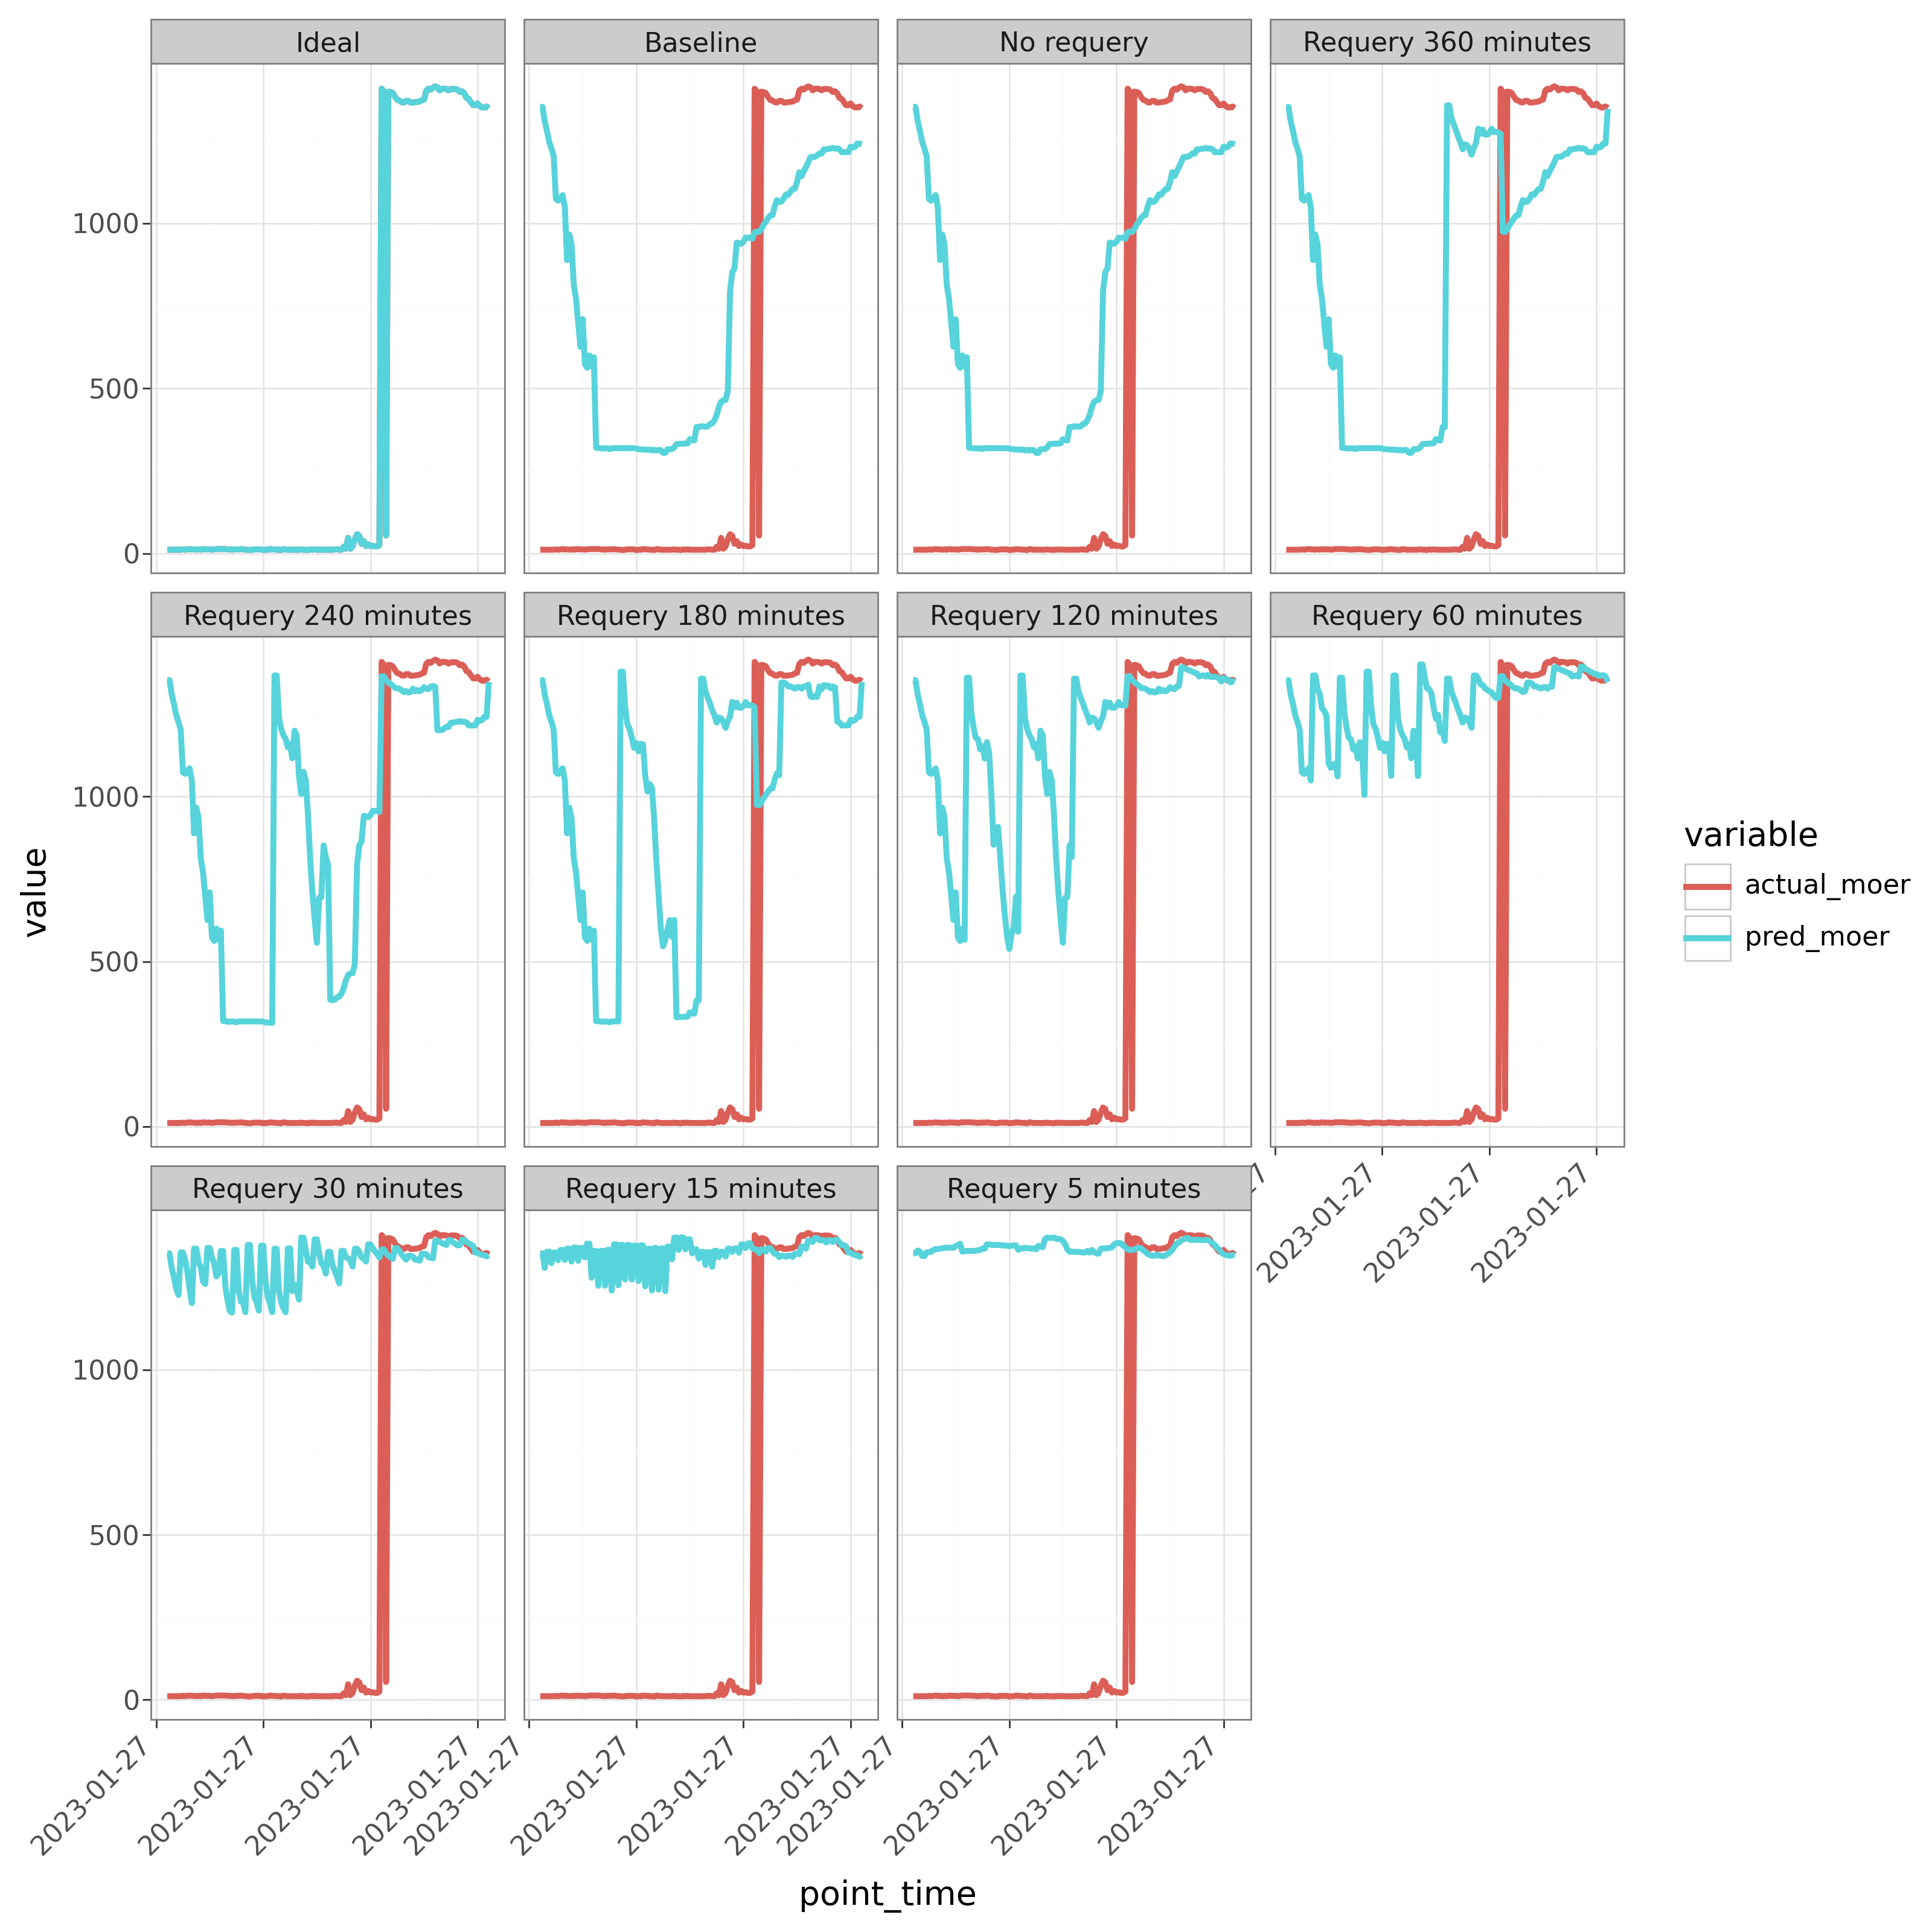

In [57]:
 (ggplot(plot_dat, aes(x="point_time", y="value", color = "variable")) +
     geom_line(size=2) +
     facet_wrap("~increment", nrow = 3) +
     theme_bw(base_size=20) +
     theme(figure_size=(16, 16),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )


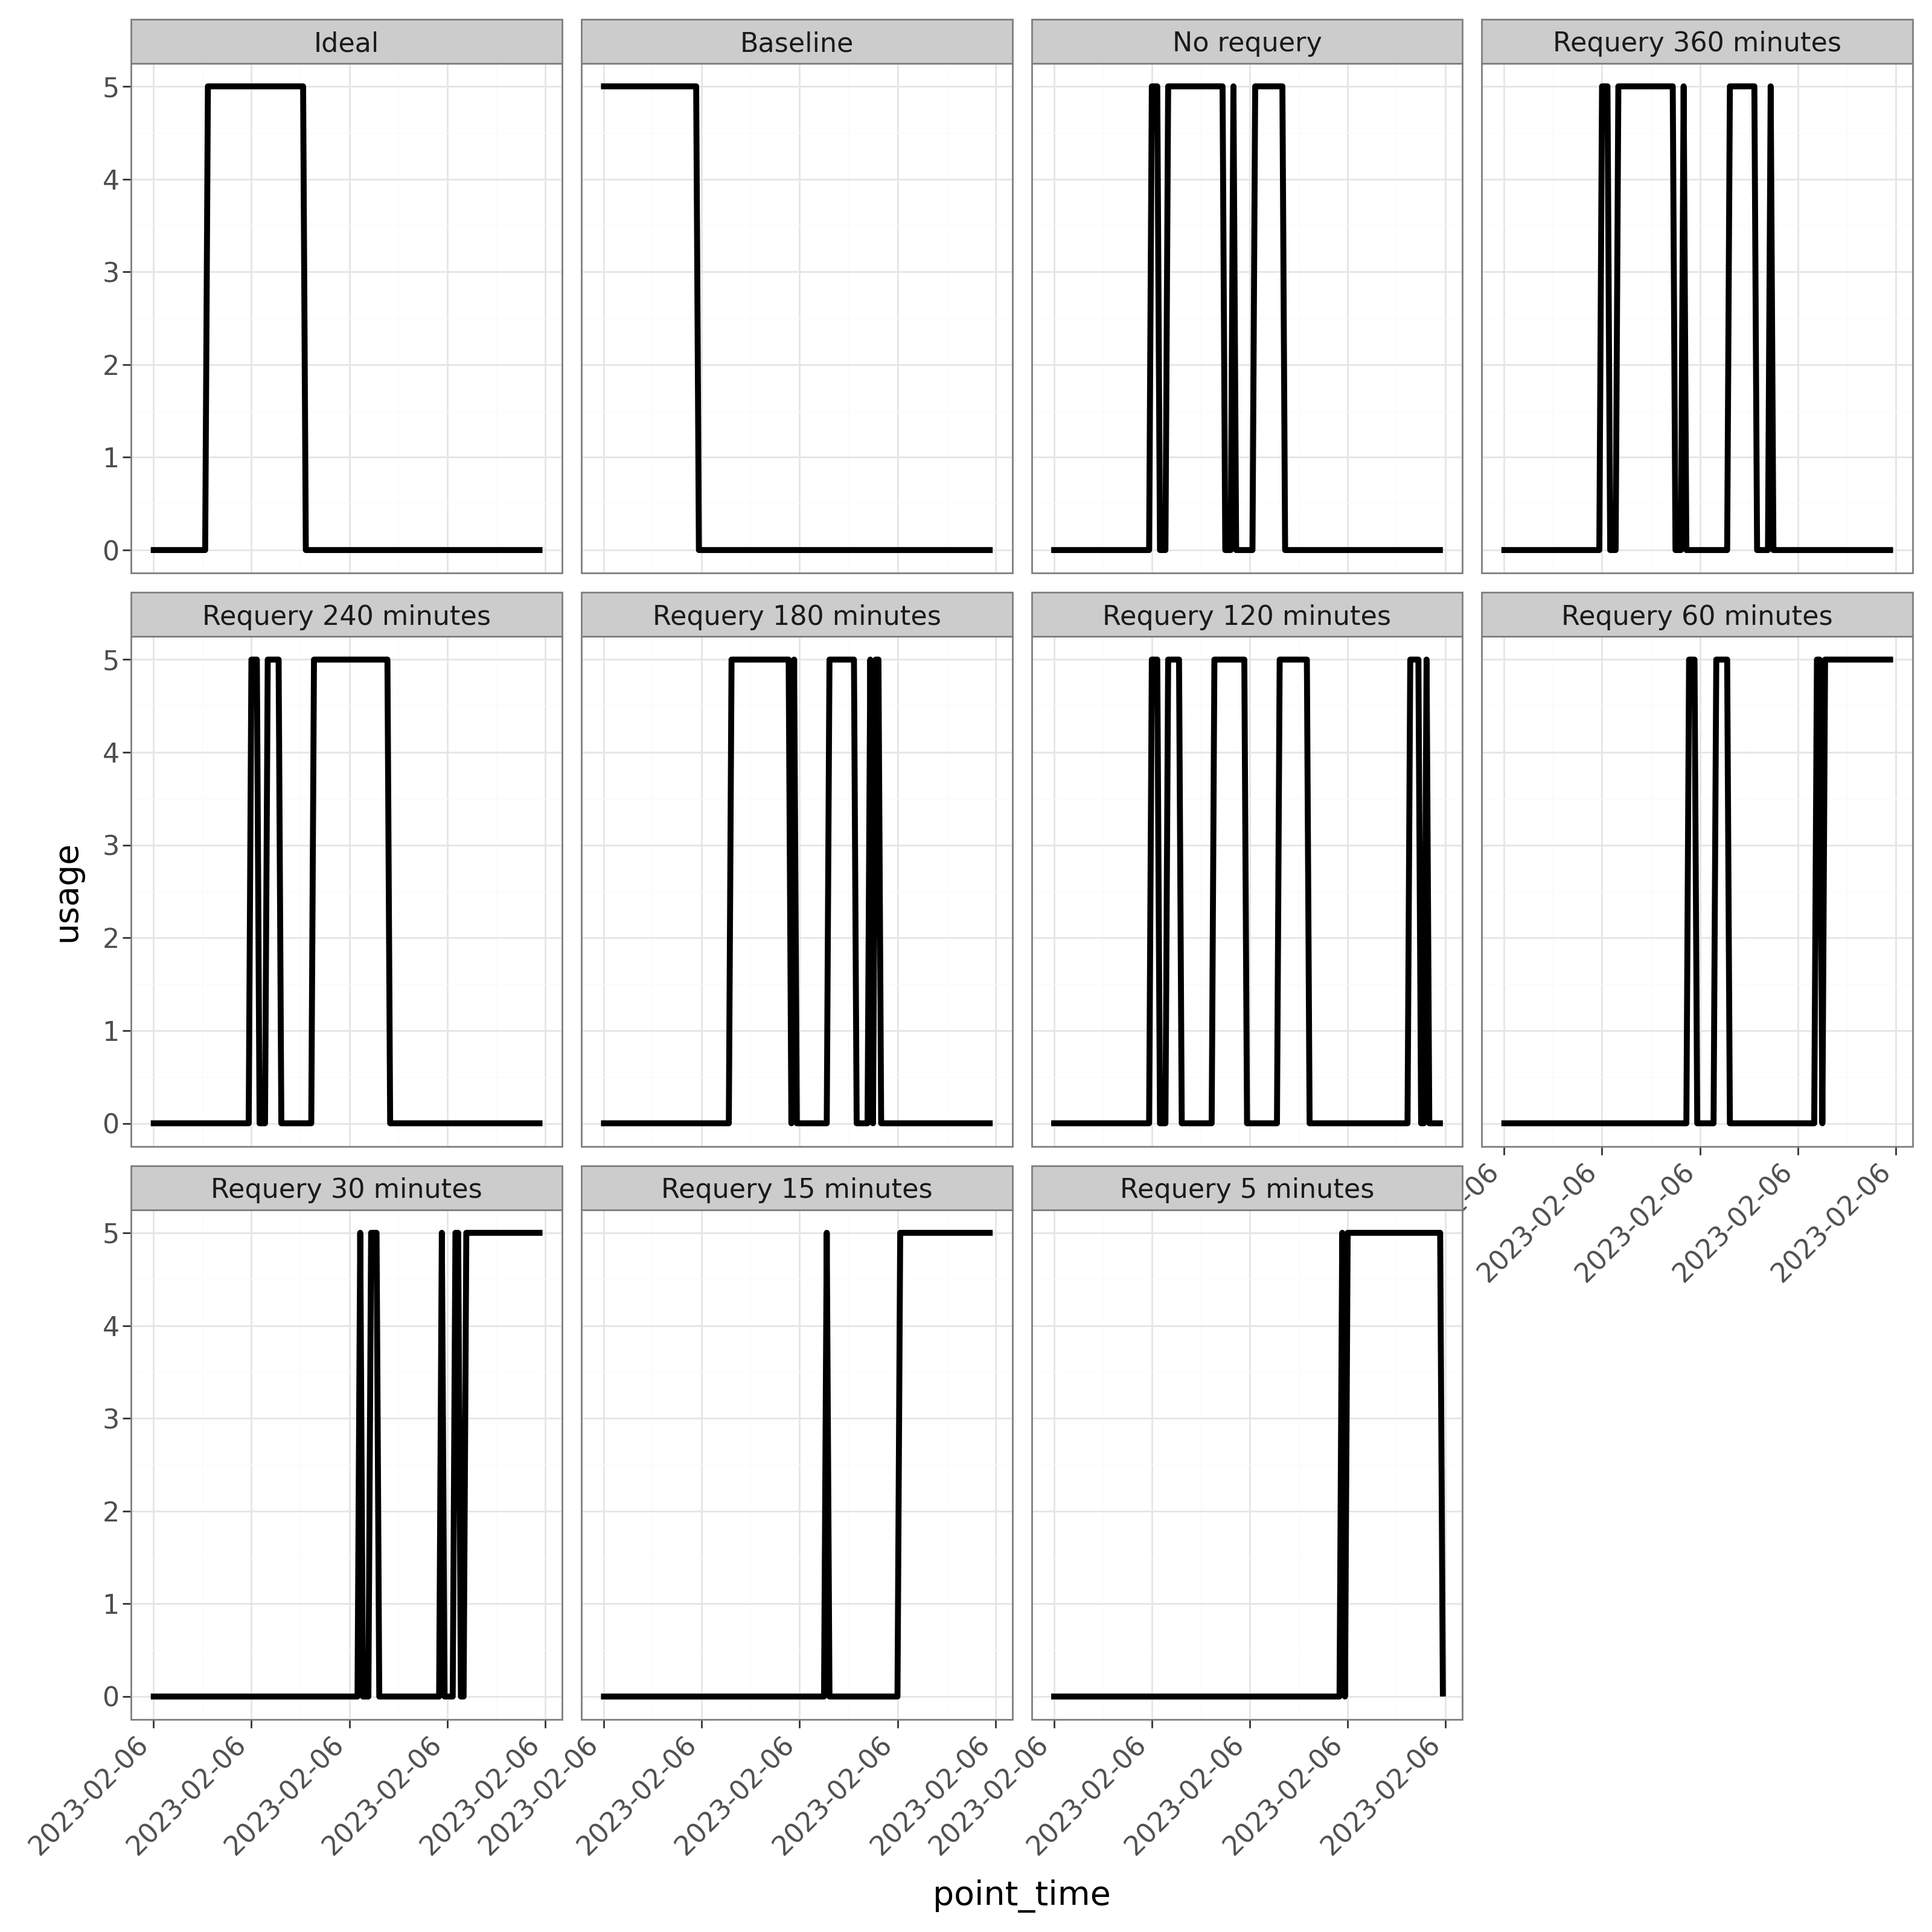

In [29]:
(ggplot(requery_results.query("unique_id == '2127805345538670419'"), aes(x="point_time", y="usage")) +
     geom_line(size=2) +
     facet_wrap("~increment", nrow = 3) +
     theme_bw(base_size=20) +
     theme(figure_size=(16, 16),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )
